In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import plotly.express as px
import plotly.graph_objects as go
from pandas_profiling import ProfileReport
from sklearn.metrics import r2_score, mean_squared_error

In [74]:
df_train = pd.read_csv("treino+k5means.csv")
df_train = df_train.drop(columns=["Unnamed: 0"])

In [75]:
df_teste = pd.read_csv("teste+k5means.csv")
df_teste = df_teste.drop(columns=["Unnamed: 0"])

In [76]:
df_train.shape

(21692, 29)

# Initialize

In [77]:
var_cat = ['BOROUGH','NEIGHBORHOOD','BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','BLOCK','LOT' ,'BUILDING CLASS AT PRESENT',
           'APARTMENT NUMBER', 'ZIP CODE','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE', 'cluster']

var_num = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT',
           'sale_month','sale_week','sale_year', 'latitude','longitude']

usable_num = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET','YEAR BUILT', 'sale_week','sale_year', 'latitude','longitude', "SALE PRICE"]

In [78]:
dataset_train = df_train.drop(columns=var_cat)
dataset_test = df_teste.drop(columns=var_cat)

# Split Data

In [79]:
X_train, y_train = dataset_train.iloc[:,1:], dataset_train.iloc[:, 0]
X_test, y_test = dataset_test.iloc[:,1:], dataset_test.iloc[:, 0]

## Random Search CV

### Random Forest

In [14]:
steps = [('scaler', MinMaxScaler()), ('RandomForest', RandomForestRegressor(n_jobs = -1))]
pipeline = Pipeline(steps)

In [18]:
param_dist = {'RandomForest__n_estimators': [100,200,500,700, 1000],
              'RandomForest__min_samples_split': [2,4,8,16,32]}

In [19]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs = -1 , cv = 10, random_state= 42, verbose = 10)

In [20]:
random_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('RandomForest',
                                              RandomForestRegressor(n_jobs=-1))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'RandomForest__min_samples_split': [2,
                                                                            4,
                                                                            8,
                                                                            16,
                                                                            32],
                                        'RandomForest__n_estimators': [100, 200,
                                                                       500, 700,
                                                                       1000]},
                   random_state=42, verbose=10)

In [21]:
random_search.score(X_test, y_test)

0.6700925188579645

In [22]:
random_search.best_params_

In [24]:
random_search.best_score_

In [30]:
random_search.cv_results_

In [31]:
random_search.best_params_

### MLP

In [12]:
steps = [('scaler', MinMaxScaler()), ('MLP', MLPRegressor())]
pipeline = Pipeline(steps)

In [16]:
param_dist = {'MLP__hidden_layer_sizes': [(100,100,1), (10,100,1), (100,200,1), (10,200,100,1) , (10,20,10,1)],
              'MLP__activation': ["relu", "tanh"], 
              'MLP__solver': ["lbfgs","adam"],
             'MLP__alpha': [10e-4,10e-3,10e-2,10e-1]}

In [17]:
n_iter_search = 20
mlp_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs = -1 , cv = 10, random_state= 42, verbose = 10)

In [36]:
mlp_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('MLP', MLPRegressor())]),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'MLP__activation': ['relu', 'tanh'],
                                        'MLP__alpha': [0.001, 0.01, 0.1, 1.0],
                                        'MLP__hidden_layer_sizes': [(10, 10, 1),
                                                                    (10, 20, 1),
                                                                    (10, 30, 1),
                                                                    (10, 20, 10,
                                                                     1),
                                                                    (10, 20, 10,
                                                                     1)],
                                        'MLP__solver': ['lbfgs']},
              

In [55]:
mlp_search.score(X_test,y_test)

-1.3617971817980745e-05

# Modelos

## Split Normal

In [80]:
xscaler = StandardScaler().fit(X_train)
yscaler = StandardScaler().fit(y_train.to_numpy().reshape(-1,1))

X_train= xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

y_train = yscaler.transform(y_train.to_numpy().reshape(-1,1))
y_test = yscaler.transform(y_test.to_numpy().reshape(-1,1))

## Random Forest

In [81]:
rfr = RandomForestRegressor(n_jobs=-1,min_samples_split = 2, n_estimators = 700)

In [82]:
#%%time
#score = cross_val_score(rfr,X_train, y_train.ravel(), cv = 10)

In [83]:
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=700, n_jobs=-1)

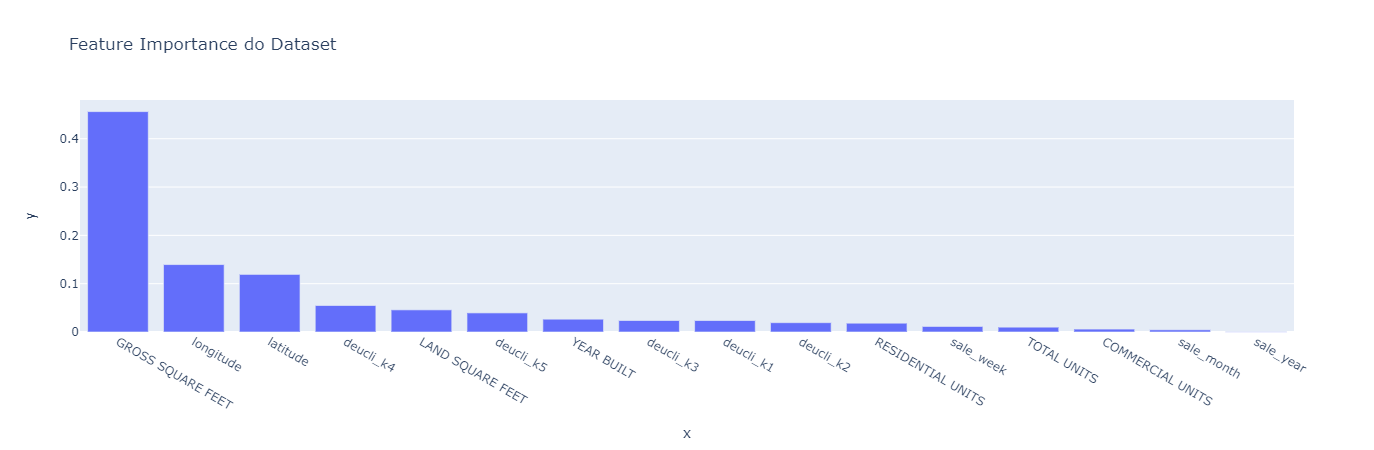

In [84]:
px.bar(x = dataset_train.columns[1:], y = rfr.feature_importances_, title = "Feature Importance do Dataset").update_xaxes(categoryorder = "total descending")

In [85]:
rfr.score(X_test,y_test)

0.6809939166534422

In [86]:
np.sqrt(mean_squared_error(y_true = y_test.ravel() , y_pred = rfr.predict(X_test)))

0.5772215507598271

## MLP

In [87]:
mlpr = MLPRegressor(hidden_layer_sizes= (100,100), activation="relu")

In [88]:
mlpr.fit(X_train, y_train.ravel())

c:\users\drocha\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor(hidden_layer_sizes=(100, 100))

In [89]:
#px.line(y = mlpr.loss_curve_,title= "Custo MLP")

In [90]:
mlpr.score(X_test, y_test) #r2

0.613105566165292

In [91]:
np.sqrt(mean_squared_error(y_true = y_test.ravel() , y_pred = mlpr.predict(X_test)))

0.6356810946752377

## SVR

In [92]:
svr = SVR(C = 8, gamma = 0.25)

In [93]:
svr.fit(X_train, y_train.ravel())

SVR(C=8, gamma=0.25)

In [94]:
svr.score(X_test,y_test.ravel())

0.6086617782702732

In [95]:
np.sqrt(mean_squared_error(y_true = y_test.ravel() , y_pred = svr.predict(X_test)))

0.6393213213134985